# Проект "Анализ пользовательского поведения в мобильном приложении"

## Описание задачи

**Заказчик: стартап, продающий продукты питания через мобильное приложение**

**Задачи от заказчика:**

1) Необходимо ответить на вопросы:

    - Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? 
    - На каких именно шагах "застревают" пользователи?
    
2) На основании проведенного A/A/B теста ответить на вопрос: "Как повлияет на пользователей изменение шрифтов в приложении?"

**Входные данные:**

Лог действий пользователей, содержащий: 
 - EventName — название события
 - DeviceIDHash — уникальный идентификатор пользователя
 - EventTimestamp — время события
 - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная

## Подготовка данных

### Импорт библиотек

In [1]:
import pandas as pd 
from IPython.display import display
import matplotlib.pyplot as plt
import math
import __main__
from scipy import stats as st
import numpy as np
import seaborn as sns
import datetime as dt
from plotly import graph_objects as go 
import math as mth

### Импорт данных

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv',sep = '\t')
display(data)
data.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков в данных нет.
Типы данных верные во всех столбцах, кроме "EventTimestamp", однако изменять его не будем, а просто выделим столбец с днем события и полной датой события. 
Также заменим имена столбцов на более удобные. 

In [3]:
data.columns = ['event_name','user_id','event_timestamp','test_group']
data['event_time'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['event_date'] = data['event_time'].dt.date
display(data)

,event_name,user_id,event_timestamp,test_group,event_time,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


Проверим данные на дубли.

In [4]:
print('Количество дублей в таблице:', data.duplicated().sum())

Количество дублей в таблице: 413


В таблице найдено 413 дублей, удалим их. Необходимо отправить запрос в отдел разработки для проверки корректности записи логов.

In [5]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
event_name         243713 non-null object
user_id            243713 non-null int64
event_timestamp    243713 non-null int64
test_group         243713 non-null int64
event_time         243713 non-null datetime64[ns]
event_date         243713 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


### Вывод

Данные обработаны, можно переходить к анализу данных. 
Необходимо отправить запрос в отдел разработки для проверки корректности записи логов - в них встречаются дубли.

## Анализ данных

Проверим, сколько всего событий в логе, сколько всего пользователей в логе и сколько в среднем событий приходится на пользователя. Мерой среднего выберем медиану, т.к. она устойчива к выбросам.

In [6]:
print('Количество событий в логе', data['user_id'].count())
print('Количество уникальных пользователей', data['user_id'].nunique())
print('Среднее количество событий на пользователя', data.groupby('user_id').agg('count')['event_name'].median())

Количество событий в логе 243713
Количество уникальных пользователей 7551
Среднее количество событий на пользователя 20.0


**Всего событий в логе - 243713 шт, количество уникальных пользователей - 7551 человек. В среднем на каждого пользователя приходится 20 событий.**

Определим, за какой период имеются данные, а также полноту данных за найденный период.

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



Text(0, 0.5, 'Количество событий, шт')

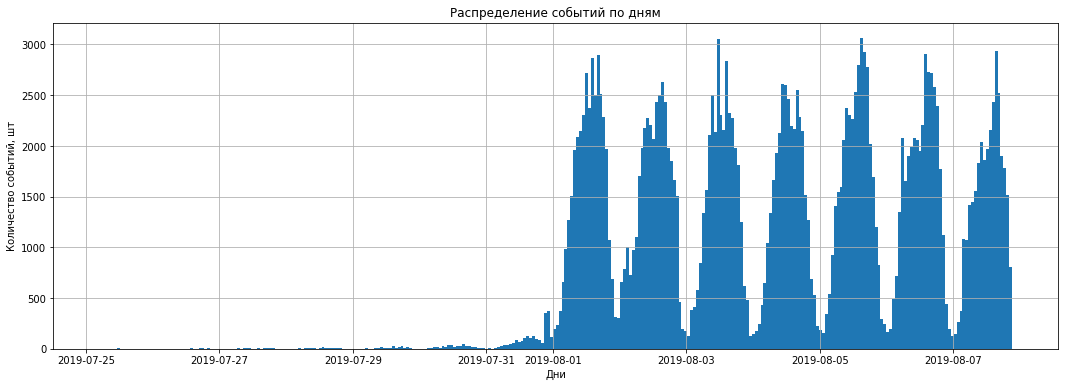

In [7]:
print('Минимальная дата:',data['event_time'].min())
print('Максимальная дата:',data['event_time'].max())

data['event_time'].hist(bins=312,figsize=(18,6));#За количество корзин взяли кол-во часов за исследуемый период 
plt.title('Распределение событий по дням')
plt.xlabel('Дни')
plt.ylabel('Количество событий, шт')

<hr style="border: 2px solid green;" />

In [10]:
data['event_time'].count()

243713

<hr style="border: 2px solid red;" />

Из графика "Распределение событий по дням" видно, что в у нас имеются данные да 7 полных дней. Также есть данные за несколько дней июля - вероятно, это старые данные, которые случайно попали в выборку. Нужный нам период начинается с 01.08.2019 - только он обеспечит нам необходимую полноту, а данные за июль могут сильно исказить результаты анализа.

Также проверим, сколько данных мы отбросили и есть не потеряли ли мы всех пользователей из какой-либо группы.

2826
Процент отброшенных данных:1.2%


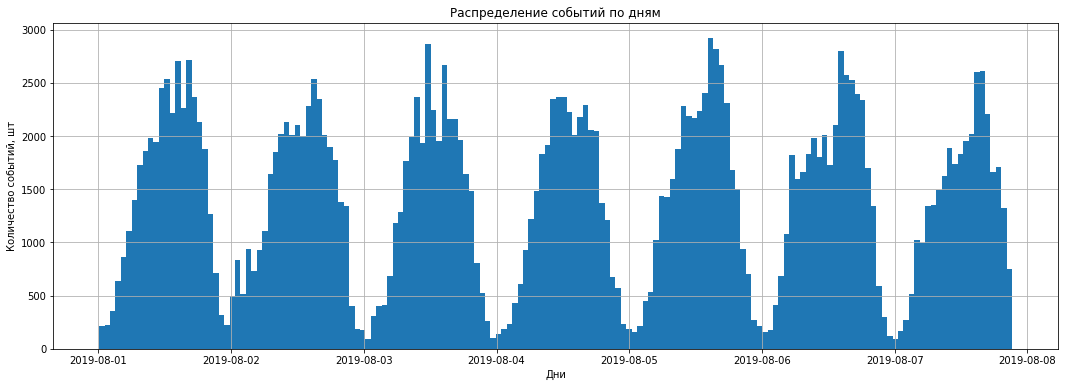

In [12]:
data_recall = data[data['event_date'] >= dt.date(2019,8,1)]
data_recall['event_time'].hist(bins=168,figsize=(18,6));#За количество корзин взяли кол-во часов за исследуемый период 
plt.title('Распределение событий по дням')
plt.xlabel('Дни')
plt.ylabel('Количество событий, шт')

print(len(data) - len(data_recall))
print('Процент отброшенных данных:{:.1%}'.format((len(data) - len(data_recall))/len(data)))

In [13]:
print('Количество событий в группах')
print(data_recall['test_group'].value_counts())

Количество событий в группах
248    84563
246    79302
247    77022
Name: test_group, dtype: int64


**Отброшенные данные составляют всего 1.2%, в "чистых" данных есть достаточное количество всех групп, поэтому далее работать будем только данными за период с 01.08.2019 по 07.08.2019.**

### Вывод

**Всего событий в логе - 243713 шт, количество уникальных пользователей - 7551 человек. В среднем на каждого пользователя приходится 20 событий.**

**Для дальнейшего анализа будем использовать данные за период с 01.08.2019 по 07.08.2019**

## Анализ воронки событий

Посмотрим, сколько событий каждого типа.

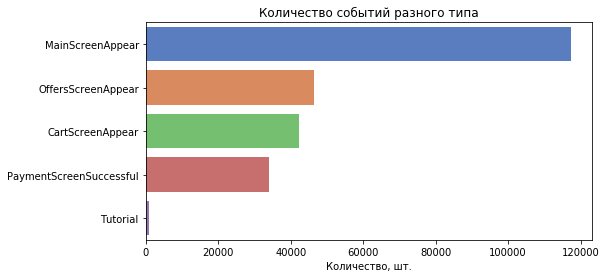

,event_name,user_id
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [14]:
plt.figure(
    figsize=(8, 4)
)
sns.set_palette('muted') 
sns.barplot(x='user_id', y='event_name', data=data_recall.groupby('event_name')['user_id'].count().reset_index().sort_values('user_id',ascending = False))
plt.title('Количество событий разного типа')
plt.ylabel('')
plt.xlabel('Количество, шт.')
plt.show()

display(data_recall.groupby('event_name')['user_id'].count().reset_index().sort_values('user_id',ascending = False))

Перед формированием выводов посмотрим на количество каждого события в среднем на пользователя, а также сколько пользователей совершали каждое из этих событий и найдем долю пользователей, которые хоть раз совершали соотвествующее событие.

Среднее количество событий по пользователям


,event_name,event_timestamp
0,MainScreenAppear,11
1,OffersScreenAppear,6
2,CartScreenAppear,5
3,PaymentScreenSuccessful,4
4,Tutorial,1


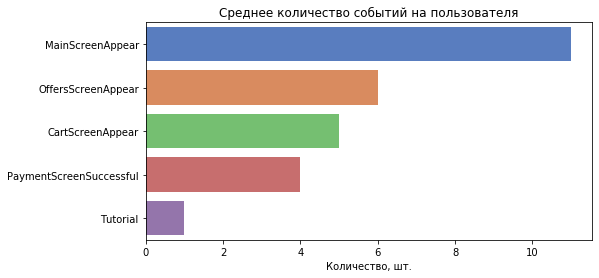

Общее количество пользователей, совершивших каждое событие и их доля


,user_id,total_conversion
event_name,,
MainScreenAppear,7419,98.5
OffersScreenAppear,4593,61.0
CartScreenAppear,3734,49.6
PaymentScreenSuccessful,3539,47.0
Tutorial,840,11.1


In [15]:
num_event_per_user = data_recall.groupby(['user_id','event_name']).agg({'event_timestamp':'count'}).reset_index().groupby('event_name').agg({'event_timestamp':'median'}).sort_values('event_timestamp',ascending = False).reset_index()
print('Среднее количество событий по пользователям')
display(num_event_per_user)
plt.figure(
    figsize=(8, 4)
)
sns.set_palette('muted') 
sns.barplot(x='event_timestamp', y='event_name', data=num_event_per_user)
plt.title('Среднее количество событий на пользователя')
plt.ylabel('')
plt.xlabel('Количество, шт.')
plt.show()

total_conversion = data_recall.pivot_table(index='event_name', values='user_id', aggfunc={'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
total_conversion['total_conversion'] = (total_conversion ['user_id'] / data_recall['user_id'].nunique() * 100).round(1)
print('Общее количество пользователей, совершивших каждое событие и их доля')
display(total_conversion)

Судя по графику "Количество событий разного типа" и "Среднее количество событий на пользователя" распределение общего количества событий совпадает с распределением среднего количества событий по пользователям. 

Событий "MainScreenAppear" всегда больше всех. На втором месте по количеству событие "OffersScreenAppear", на третьем "CartScreenAppear" и на четвертом "PaymentScreenSuccessful". Событие "Tutorial", как правило, самое редкое. 

**Возможно, события можно интерпретировать так:**

MainScreenAppear - пользователь увидел главный экран приложения

OffersScreenAppear - пользователь увидел экран с предложением товаров

CartScreenAppear - пользователь увидел корзину

PaymentScreenSuccessful - пользователь увидел экран с сообщением об успешной покупке

Tutorial - пользователь увидел экран обучения или начал/завершил обучение. 

**Скорее всего, последовательная цепочка действий пользователя в воронке имеет следующий порядок:**

    1) MainScreenAppear
    2) OffersScreenAppear
    3) CartScreenAppear
    4) PaymentScreenSuccessful

Событие "Tutorial" намеренно не включаем в воронку, т.к. совсем не обязательно проходить обучение, что бы совершить покупку и наоборот. 

Судя по полученным данным больше всего пользователей теряется после того, как видят главный экран приложения. Возможно, с главным экраном что-то не так и изменение шрифтов как раз позволит увеличить конверсию перехода на следующий этап. Можно отметить, что пользователь, добавивший товар в корзину, как правило, его покупает.

**По графику "Среднее количество событий на пользователя" видно, что за неделю с первого по седьмое августа 2019 года пользователи делали в среднем 4 покупки и видел всего 6 страниц с продуктом - возможно, стоит "помочь" пользователю выгодно докупить к своему товару еще какой-то с помощью рекомендаций. Это может повысить средний чек.** 

**98,5% прользователей видят главную страницу. Остальные 1,5%, судя по всему, переходят в приложение с рекламных баннеров на определенные продукты и сразу видят предложения к покупке. Либо это могут быть пользователи, которые совершили действия до 01.08.2019, которые мы не испольуем в расчетах.**

Рассмотрим подробнее воронку продаж и найдем конверсию последовательных переходов по этапам. Также дополнительно рассмотрим воронку продаж по каждой группу отдельно.

In [1]:

def init_metrics (group = 'noneparam'):
    
    if group == 'noneparam':
        users = data_recall.pivot_table(
            index='user_id', 
            columns='event_name', 
            values='event_time',
            aggfunc='min'
        )
    else :
         users = data_recall.query('test_group == @group').pivot_table(
            index='user_id', 
            columns='event_name', 
            values='event_time',
            aggfunc='min'
            )
   

    step_1 = ~users['MainScreenAppear'].isna() 
    step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear']) 
    step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
    step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear']) 

    n_pageview = users[step_1].shape[0] 
    n_add_to_cart = users[step_2].shape[0] 
    n_checkout = users[step_3].shape[0] 
    n_payment = users[step_4].shape[0]
    
    return n_pageview,n_add_to_cart,n_checkout,n_payment


def add_trace (group = 'noneparam'):
    fig.add_trace(go.Funnel(
    name = group,
     y = ["Посетителей","Увидели экран продукта", "Увидели корзину", "Оплатили заказы"],
     x = init_metrics(group),
    textinfo = "value+percent initial"))

fig1 = go.Figure(go.Funnel(
    y = ["Посетителей","Увидели экран продукта", "Увидели корзину", "Оплатили заказы"],
    x = init_metrics()
    ))
fig1.update_layout(title_text='Воронка событий по всем пользователям')
fig1.show()    
    
fig = go.Figure()
fig.update_layout(title_text='Воронка событий по пользователям из разных групп')
for each in data_recall['test_group'].unique():
    add_trace(each.astype(str))

fig.show()



NameError: name 'go' is not defined

**Конверсия переходов по этапа пользователей:**

    - с этапа "MainScreenAppear (увидел главный экран)" на "OffersScreenAppear(увидел экран продукта)" конверсия составляет 56,6% 
    - с этапа "OffersScreenAppear(увидел экран продукта)" на "CartScreenAppear(увидел корзину)" конверсия составляет 42,1% 
    - с этапа "CartScreenAppear(увидел корзину)" на "PaymentScreenSuccessful(увидел экран с успешной оплатой)" конверсия составляет 25,7% 
  

**Из графика "Воронка событий по всем пользователям" видно, что больше всего пользователей по количеству теряется после просмотра главного экрана приложения - 44,4%  или 3218 пользователей от общего числа уходят. Это может говорить о том, что предположения о проблемах на главном экране может быть верно.**

**Заказчику рекомендуется провести дополнительное исследование для определения факторов, влияющих на показатель конверсии переходов с главного экрана на экран с предложением продуктов.**

**Однако если судить по относительным показателям, то больше всего посетителей теряется после того, как увидят корзину - 74,3% или 1313 пользователей не совершают покупку после того, как посетят корзину. Пользователей может пугать общая стоимость, а, может быть, на этом экране отображается время доставки и оно не устраивает посетителей - стоит проверить и принять меры.** 

**Из всех посетителей оплатило свои заказы только 6,1%.** 

**Для разных групп конверсия на каждом шаге практически совпадает с общей конверсией - данные разнятся в пределах 1%.** Однако Конверсия покупки после просмотра корзины у экспериментальной группы 248 выше на 4,3%.  Необходимо проверить, есть ли значимые различия между группами. 

## Анализ результатов A/A/B теста

Для начала посмотрим, сколько пользователей в каждой группе.

In [17]:
print('Количество пользователей в каждой группе:')
display(data_recall.groupby('test_group').agg({'user_id':'nunique'}).reset_index())

Количество пользователей в каждой группе:


,test_group,user_id
0,246,2484
1,247,2513
2,248,2537


Выберем самое популярное событие, посчитаем количество пользователей с которыми оно произошло.  

In [21]:
display(data_recall.groupby(['event_name','test_group']).agg({'user_id':'nunique'}).reset_index())


,event_name,test_group,user_id
0,CartScreenAppear,246,1266
1,CartScreenAppear,247,1238
2,CartScreenAppear,248,1230
3,MainScreenAppear,246,2450
4,MainScreenAppear,247,2476
5,MainScreenAppear,248,2493
6,OffersScreenAppear,246,1542
7,OffersScreenAppear,247,1520
8,OffersScreenAppear,248,1531
9,PaymentScreenSuccessful,246,1200


Самое популярное событие - "MainScreenAppear". Количество пользователей, которое его совершили, по группам:

    Группа 246 - 2450
    Группа 247 - 2476
    Группа 248 - 2493

In [22]:
sample_A1 = data_recall[data_recall['test_group'] == 246].reset_index()
sample_A2 = data_recall[data_recall['test_group'] == 247].reset_index()
sample_B = data_recall[data_recall['test_group'] == 248].reset_index()



Для проверки значимости гипотезы о равенстве долей напишем функцию. Т.к. далее планируется проводить несколько сравнений для одних и тех же данных, то применим метод Шидака для корректировки критического уровня статистической значимости: всего планируется провести 16 сравнений на одних и тех же данных ( сравнение групп 246 и 247, 246 и 248, 247 и 248, 246_247 и 248 по 4 события). 

In [23]:
sidak = 1-(1-0.05)**(1/16)
print('Необходимый критический уровень значимости',sidak)

Необходимый критический уровень значимости 0.0032006977101884937


Т.к. в данном случае нас интересует значимая разница в конверсии переходов по этапам воронки, то далее для проверки статистической значимости будем использовать z-тест о равенстве долей. 

**Необходимый критический уровень значимости 0.0032006977101884937**

In [24]:
#на входе две сравниваемые выборки, событие и крит. уровень стат. значимости
def z_test(sample_1, sample_2, event_name, alpha=0.05): 
    # критический уровень статистической значимости
    alpha = alpha
    
    # число успехов это число уникальных ползователей в событие группы
    successes_1 = sample_1[sample_1['event_name'] == event_name]['user_id'].nunique()
    successes_2 = sample_2[sample_2['event_name'] == event_name]['user_id'].nunique()
    
    # число попыток это число уникальных ползователей в группе
    trials_1 = sample_1['user_id'].nunique()
    trials_2 = sample_2['user_id'].nunique()
    
    #пропорция успехов в первой группе:
    p1 = successes_1 / trials_1
    #пропорция успехов во второй группе:
    p2 = successes_2 / trials_2
    #пропорция успехов в комбинированном датасете:
    p_combined  = (successes_1 + successes_2) / (trials_1 + trials_2)
    #разница пропорций в датасетах
    difference = p1 - p2
    
    #считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined  *  (1 - p_combined ) * (1 / trials_1 + 1 / trials_2))
    
    #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('В группе', sample_1['test_group'][0],'в событии', event_name,
          f'{successes_1} пользователей, 'f'доля совершивших это событие: {p1:.1%}')
    print('В группе', sample_2['test_group'][0],'в событии', event_name,
          f'{successes_2} пользователей, 'f'доля совершивших это событие: {p2:.1%}')
    
    print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу, между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

Проверим, будут ли статистически значимые отличия в долях выборок 246 и 247 по всем событиям из воронки. 

Формируем гипотезы:

    H0 - Доли сравниваемых выборок равны 
    H1 - Между долями выборок есть статистически значимые различия

In [25]:
events = ['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful']

for each in events:
    z_test(sample_A1, sample_A2, each, alpha=sidak)
    print()

В группе 246 в событии MainScreenAppear 2450 пользователей, доля совершивших это событие: 98.6%
В группе 247 в событии MainScreenAppear 2476 пользователей, доля совершивших это событие: 98.5%
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

В группе 246 в событии OffersScreenAppear 1542 пользователей, доля совершивших это событие: 62.1%
В группе 247 в событии OffersScreenAppear 1520 пользователей, доля совершивших это событие: 60.5%
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

В группе 246 в событии CartScreenAppear 1266 пользователей, доля совершивших это событие: 51.0%
В группе 247 в событии CartScreenAppear 1238 пользователей, доля совершивших это событие: 49.3%
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

В группе 246 в событии PaymentScreenSuccessful 1200 пользователей, доля совершивших эт

Для всех событий отвергнута нулевая гипотеза - значит, нет статистически значимых различий между группами 246 и 247. 

Т.к. для всех событий групп 246 и 247 мы не получили подвтерждение статистически значимых различий, значит разбиение по группам работает верно и можно приступать к проверке с экспериментальной группой.

Проверим, есть ли статистически значимые различия долей между группами 246 и 248 по всем событиям из воронки.

Формируем гипотезы:

    H0 - Доли сравниваемых выборок равны 
    H1 - Между долями выборок есть статистически значимые различия

In [26]:
for each in events:
    z_test(sample_A1, sample_B, each, alpha=sidak)
    print()

В группе 246 в событии MainScreenAppear 2450 пользователей, доля совершивших это событие: 98.6%
В группе 248 в событии MainScreenAppear 2493 пользователей, доля совершивших это событие: 98.3%
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

В группе 246 в событии OffersScreenAppear 1542 пользователей, доля совершивших это событие: 62.1%
В группе 248 в событии OffersScreenAppear 1531 пользователей, доля совершивших это событие: 60.3%
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

В группе 246 в событии CartScreenAppear 1266 пользователей, доля совершивших это событие: 51.0%
В группе 248 в событии CartScreenAppear 1230 пользователей, доля совершивших это событие: 48.5%
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

В группе 246 в событии PaymentScreenSuccessful 1200 пользователей, доля совершивших э

Для всех событий отвергнута нулевая гипотеза - значит, нет статистически значимых различий между группами 246 и 248. 

Проверим, есть ли статистически значимые различия долей между группами 247 и 248 по всем событиям из воронки.

Формируем гипотезы:

    H0 - Доли сравниваемых выборок равны 
    H1 - Между долями выборок есть статистически значимые различия

In [27]:
for each in events:
    z_test(sample_A2, sample_B, each, alpha=sidak)
    print()

В группе 247 в событии MainScreenAppear 2476 пользователей, доля совершивших это событие: 98.5%
В группе 248 в событии MainScreenAppear 2493 пользователей, доля совершивших это событие: 98.3%
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

В группе 247 в событии OffersScreenAppear 1520 пользователей, доля совершивших это событие: 60.5%
В группе 248 в событии OffersScreenAppear 1531 пользователей, доля совершивших это событие: 60.3%
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

В группе 247 в событии CartScreenAppear 1238 пользователей, доля совершивших это событие: 49.3%
В группе 248 в событии CartScreenAppear 1230 пользователей, доля совершивших это событие: 48.5%
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

В группе 247 в событии PaymentScreenSuccessful 1158 пользователей, доля совершивших это

Для всех событий отвергнута нулевая гипотеза - значит, нет статистически значимых различий между группами 247 и 248. 

**Таким образом получаем, что по отдельности нет статистически значимой разницы между группами 246,247 и 248. Интересно, что даже не меняя критический уровень значимости (оставив значение 0.05) мы бы не получили статистически значимые различия, что дополнительно подтверждает результаты проверки.**

Дополнительно проверим, есть ли статистически значимые различия в долях между группой 248 и объединенной выборкой из групп 246 и 247.

Формируем гипотезы:

    H0 - Доли сравниваемых выборок равны 
    H1 - Между долями выборок есть статистически значимые различия

In [28]:
for each in events:
    z_test(data_recall[(data_recall['test_group'] == 246) | (data_recall['test_group'] == 247)].reset_index(), sample_B, each, alpha=sidak)
    print()

В группе 246 в событии MainScreenAppear 4926 пользователей, доля совершивших это событие: 98.6%
В группе 248 в событии MainScreenAppear 2493 пользователей, доля совершивших это событие: 98.3%
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

В группе 246 в событии OffersScreenAppear 3062 пользователей, доля совершивших это событие: 61.3%
В группе 248 в событии OffersScreenAppear 1531 пользователей, доля совершивших это событие: 60.3%
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

В группе 246 в событии CartScreenAppear 2504 пользователей, доля совершивших это событие: 50.1%
В группе 248 в событии CartScreenAppear 1230 пользователей, доля совершивших это событие: 48.5%
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

В группе 246 в событии PaymentScreenSuccessful 2358 пользователей, доля совершивших 

**Для всех событий отвергнута нулевая гипотеза - значит, нет статистически значимых различий между группой 248 и выборкой из объединенных групп 246,247.** 

### Вывод

**В результате анализа результатов теста и проведения проверки значимости различий между группами 246,247 и 248 с помощью z-теста было выявлено, что значимых различий между группами нет. Это означает, что изменение шрифта никак не повлияла на пользователей из контрольной группы - данное изменение не принесет никакой выгоды заказчику, но и не принесет негативный эффект.**

## Итоговый вывод

Всего событий в логе - 243713 шт, количество уникальных пользователей - 7551 человек. В среднем на каждого пользователя приходится 20 событий.

Анализ проводился на данных за период с 01.08.2019 по 07.08.2019

Конверсия переходов по этапа пользователей:

    - с этапа "увидел главный экран" на "увидел экран продукта" конверсия составляет 56,6% 
    - с этапа "увидел экран продукта" на "увидел корзину" конверсия составляет 42,1% 
    - с этапа "увидел корзину" на "увидел экран с успешной оплатой" конверсия составляет 25,7% 
    
Конверсия в группах 246,247 и 248 практически одинакова на всех этапах и отличается в среднем на 1%. 
  
Больше всего пользователей (в количественных величинах) теряется после просмотра главного экрана приложения - 44,4% или 3218  пользователей от общего числа уходят. Это может говорить о том, что предположения о проблемах на главном экране может быть верно. Рекомендуется провести дополнительное исследование для определения факторов, влияющих на показатель конверсии переходов с главного экрана на экран с предложением продуктов.

Больше всего пользователей (в относительных мерах) теряется после того, как увидят корзину - 74,3% или 1313 пользователей не совершают покупку после того, как посетят корзину. Пользователей может пугать общая стоимость, или, может быть, на этом экране отображается время доставки и оно не устраивает посетителей - стоит проверить и принять меры.

Из всех посетителей оплатило свои заказы только 6,1%.

**В результате анализа результатов теста и проведения проверки значимости различий между группами 246,247 и 248 с помощью z-теста было выявлено, что значимых различий между группами нет. Это означает, что изменение шрифта никак не повлияло на пользователей из контрольной группы - данное изменение не принесет никакой выгоды заказчику, но и не принесет негативный эффект.**


Рекомендуется обратиться в отдел разработки для проверки корректности записи логов - в них встречаются дубли.
